In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers,models
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
IMAGE_SIZE = 256
CHANNELS = 3
EPOCH = 50
BATCH_SIZE = 32

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory("chest_xray_dataset",shuffle=True,
                                                    image_size=(IMAGE_SIZE,IMAGE_SIZE),
                                                    batch_size=BATCH_SIZE)

Found 5216 files belonging to 2 classes.


In [4]:
dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [5]:
class_name = dataset.class_names

In [6]:
for image_batch ,label_batch in dataset.take(1):
    print(image_batch[0])

tf.Tensor(
[[[58.062836  58.062836  58.062836 ]
  [50.691406  50.691406  50.691406 ]
  [49.1622    49.1622    49.1622   ]
  ...
  [22.246277  22.246277  22.246277 ]
  [16.070312  16.070312  16.070312 ]
  [ 8.072693   8.072693   8.072693 ]]

 [[56.937836  56.937836  56.937836 ]
  [48.41797   48.41797   48.41797  ]
  [48.617737  48.617737  48.617737 ]
  ...
  [22.963165  22.963165  22.963165 ]
  [13.140625  13.140625  13.140625 ]
  [ 6.6523438  6.6523438  6.6523438]]

 [[61.449036  61.449036  61.449036 ]
  [47.66629   47.66629   47.66629  ]
  [45.53665   45.53665   45.53665  ]
  ...
  [20.234375  20.234375  20.234375 ]
  [13.77121   13.77121   13.77121  ]
  [ 5.9884644  5.9884644  5.9884644]]

 ...

 [[ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  ...
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]
  [ 0.         0.         0.       ]]

 [[ 0.         0.         0.       ]
  [ 0.         0.         

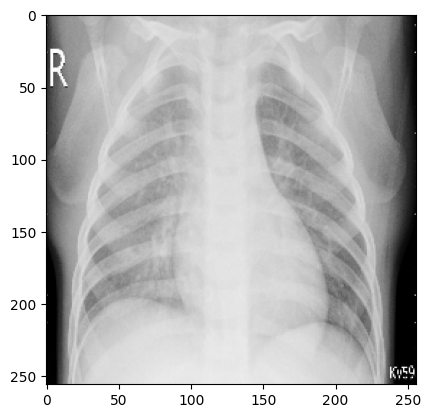

In [7]:
for image_batch ,label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))

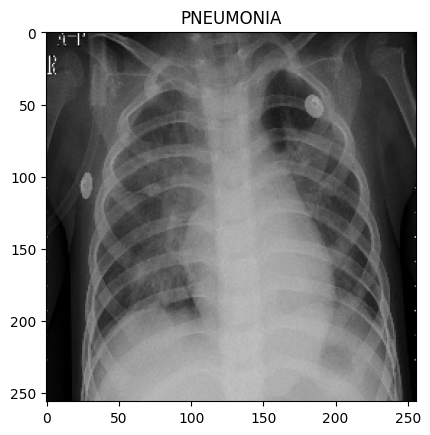

In [8]:
for image_batch ,label_batch in dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_name[label_batch[0]])

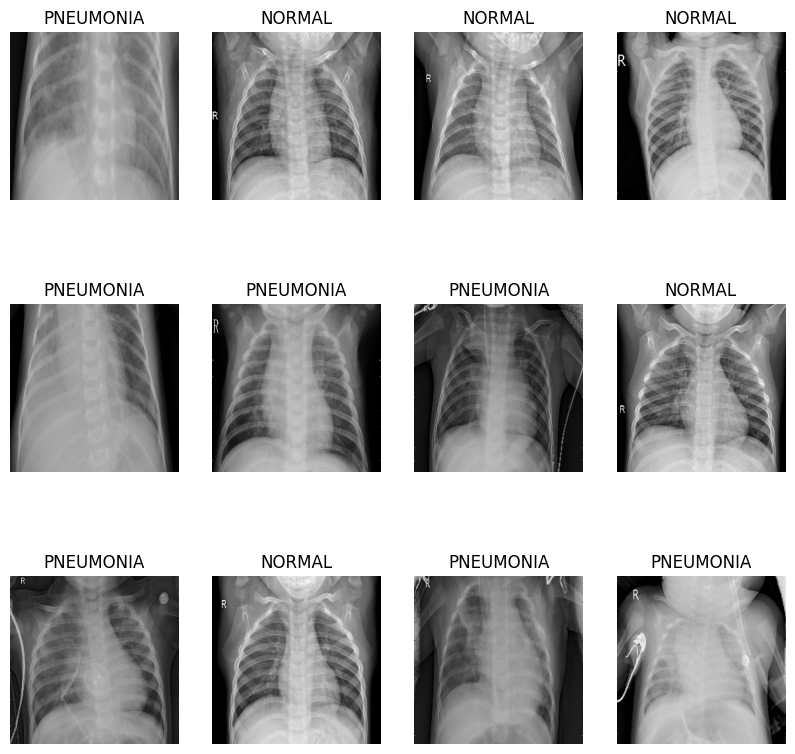

In [9]:
plt.figure(figsize=(10,10))
for image_batch ,label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.axis("off")
        plt.title(class_name[label_batch[i]])

In [10]:
len(dataset)

163

In [11]:
len(dataset)*0.8

130.4

In [12]:
# test_ds = 163 - 130
# test_ds # 33

In [13]:
# len(dataset)*0.1
# validation_ds # 16

In [14]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_split=0.1,shuffle=True,
                              shuffle_size=10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size,seed=12)

    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)

    train_ds = ds.take(train_size)

    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds,val_ds,test_ds

In [15]:
train_ds,val_ds,test_ds = get_dataset_partitions_tf(dataset)

In [16]:
len(train_ds)

130

In [17]:
len(val_ds)

16

In [18]:
len(test_ds)

17

In [19]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [20]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Rescaling(IMAGE_SIZE,IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [21]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

In [22]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
n_classes = 2

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32,(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(n_classes,activation='softmax'),
])
model.build(input_shape=input_shape)

In [23]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [24]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [25]:
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

In [26]:
tf.test.is_built_with_cuda()

False

In [29]:
EPOCH = 15

In [30]:
history = model.fit(train_ds,epochs=EPOCH,
                       batch_size=BATCH_SIZE,
                       verbose=1,
                       validation_data=val_ds)

Epoch 1/15
130/130 [==============================] - 124s 954ms/step - loss: 0.3033 - accuracy: 0.8726 - val_loss: 0.2783 - val_accuracy: 0.8789
Epoch 2/15
130/130 [==============================] - 124s 955ms/step - loss: 0.2548 - accuracy: 0.8969 - val_loss: 0.2270 - val_accuracy: 0.9141
Epoch 3/15
130/130 [==============================] - 125s 958ms/step - loss: 0.2418 - accuracy: 0.9029 - val_loss: 0.1787 - val_accuracy: 0.9395
Epoch 4/15
130/130 [==============================] - 124s 955ms/step - loss: 0.2109 - accuracy: 0.9197 - val_loss: 0.1752 - val_accuracy: 0.9414
Epoch 5/15
130/130 [==============================] - 124s 954ms/step - loss: 0.2327 - accuracy: 0.9067 - val_loss: 0.1746 - val_accuracy: 0.9375
Epoch 6/15
130/130 [==============================] - 124s 956ms/step - loss: 0.2151 - accuracy: 0.9154 - val_loss: 0.1743 - val_accuracy: 0.9316
Epoch 7/15
130/130 [==============================] - 124s 955ms/step - loss: 0.2075 - accuracy: 0.9154 - val_loss: 0.1591 -

In [31]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [32]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and validation loss')

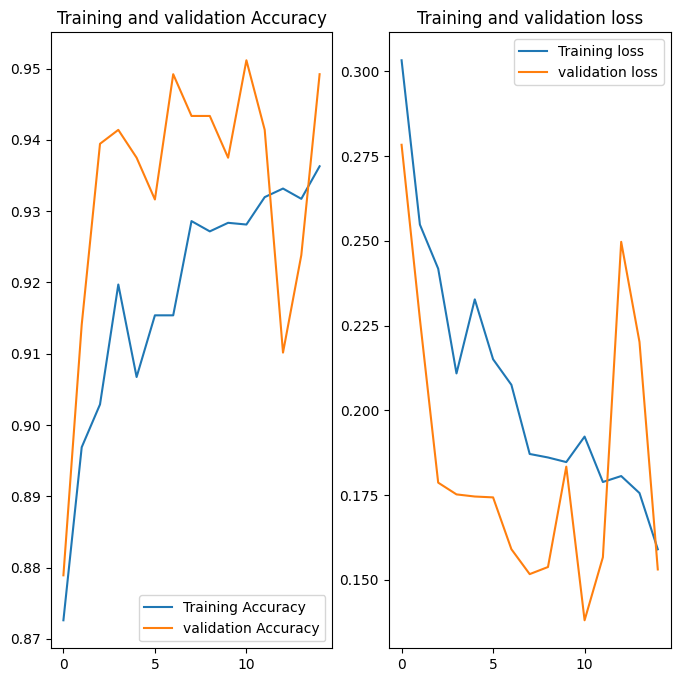

In [33]:
plt.figure(figsize=(8,8))
plt.subplot(1,2,1)
plt.plot(range(EPOCH),acc,label='Training Accuracy')
plt.plot(range(EPOCH),val_acc,label='validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and validation Accuracy')

plt.subplot(1,2,2)
plt.plot(range(EPOCH),loss,label='Training loss')
plt.plot(range(EPOCH),val_loss,label='validation loss')
plt.legend(loc='upper right')
plt.title('Training and validation loss')

In [34]:
model.save('Chest_XRay.h5')

C:\Users\visha\myenv\lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [40]:
def predict(model,img):
    img_array = tf.keras.preprocessing.image.img_to_array(image[i].numpy())
    img_array = tf.expand_dims(img_array,0)
    predication = model.predict(img_array)
    predicted_class = class_name[np.argmax(predication[0])]
    confidence = round(100*(np.max(predication[0])),2)
    return predicted_class,confidence

1/1 [==============================] - 0s 25ms/step


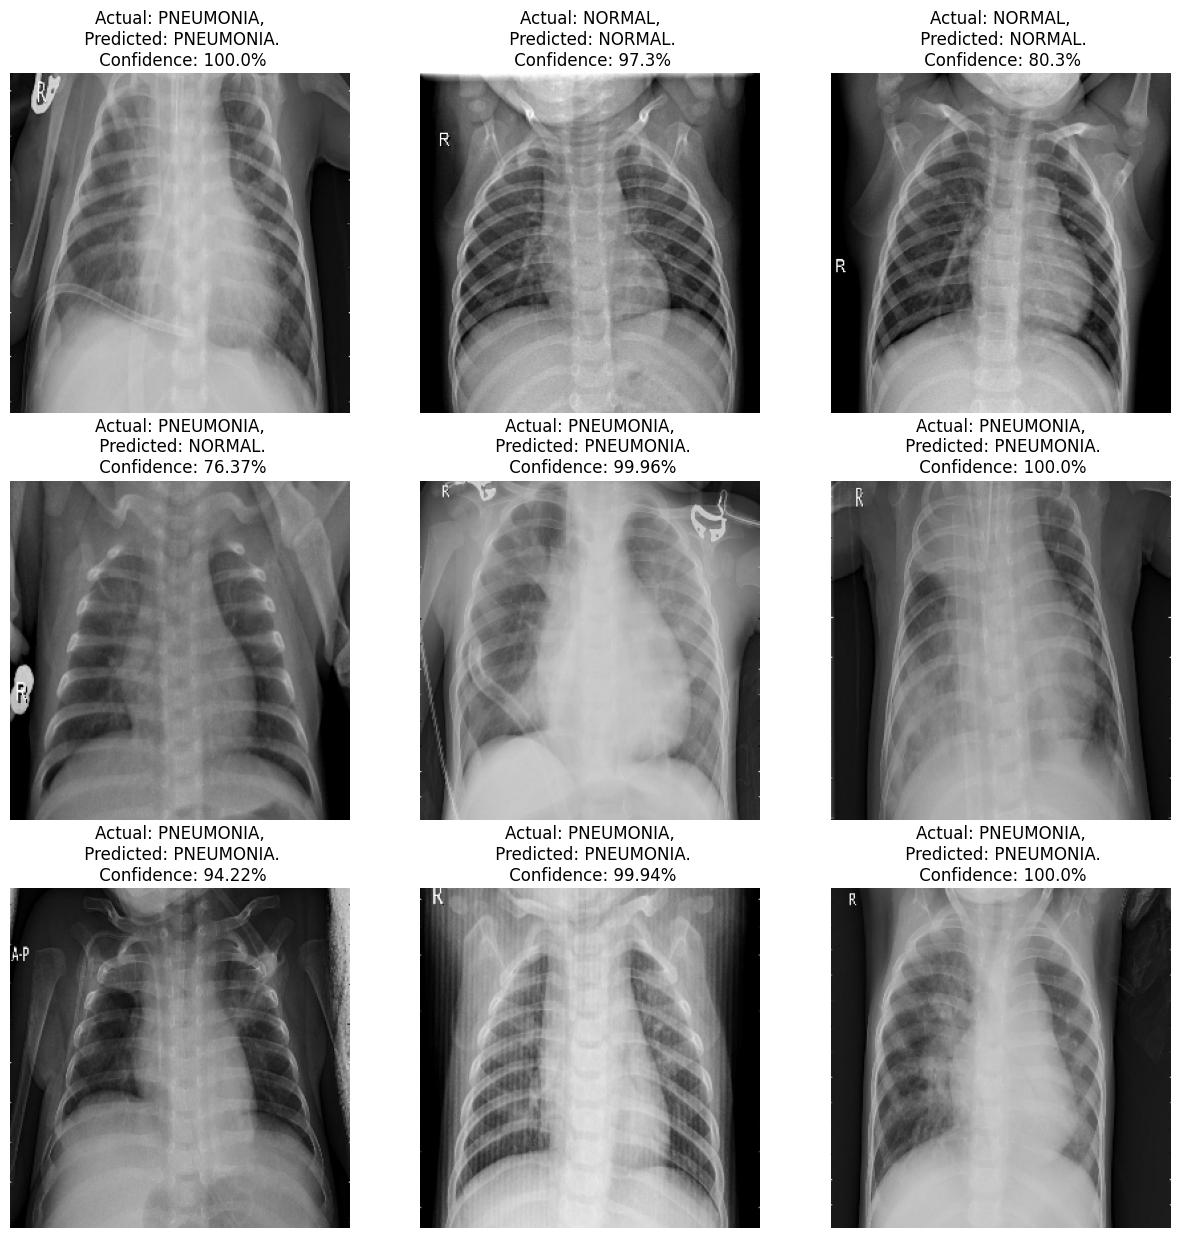

In [41]:
plt.figure(figsize=(15,15))
for image,labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(image[i].numpy().astype("uint8"))

        predicted_class,confidence = predict(model,image[i].numpy())
        actual_class = class_name[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")
        plt.axis("off")